## Steps 
- Import cost & energy library 
- calculate energy and Li content for standard cells (NMC622, NMC811, LFP, SSB) 
- take assumption for 2030 distribution
- calculate extrem in case only one chemistry exists 

In [1]:
import math
import sys
sys.path.insert(0, '/home/matthias/Documents/GitHub/Cell_model_energy_costs')
import cell_model as Cellmodel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define materials 

In [2]:
# Active materials
NMC811_cathode = Cellmodel.Activematerial_cathode("NMC811" , 
                                                  195, # specificy capacity 
                                                  3.86 # average E vs Li
                                                 )
NMC622_cathode = Cellmodel.Activematerial_cathode("NMC622" , 181, 3.86)
LFP_cathode = Cellmodel.Activematerial_cathode("LFP", 160, 3.3)
Gr = Cellmodel.Activematerial_anode("Gr", 344 , 0.17)
LiM = Cellmodel.Activematerial_anode("LiMetall", 3862, 0.0)

## Current Collectors, Eleytrolytes and Separators

The cathode will need to contain solid electrolte as well, if we want to have a true ALL solid state battery, not something quasi-solid state. 20% will be challenging enough to make the performance work, everything below would be even better...

In [3]:
### Others
## Currentcollectors 
Al = Cellmodel.CurrentCollector_cathode("Al", 14e-4 , 2.76)
Cu = Cellmodel.CurrentCollector_anode("Cu", 8e-4 , 8.96)


## Electrolyte 

fraction_SE_C = 0.20 # fraction of solid electrolyte in cathode composite

# 
LP40_standard = Cellmodel.Electrolyte_liquid("LiPF6" , 
                                             "EC:DMC", 
                                             1.1, # molar concentration mol/L 
                                             151.9 # molarmass salt 
                                            )

LLZO_elyte = Cellmodel.Electrolyte_solid("LLZO",
                                         838.5, # molarmass electrolyte
                                         6.94, # molarmass
                                         7, # index Li in LLZO
                                         fraction_SE_C, # fraction of SE in pos electrode
                                         5.1 # density in g cm-3
                                        )

Elyte_liquid = Cellmodel.Electrolyte_liquid("","",0,0) # need to define as a empty container for the function ...
                                                        # to work 
# Separator
Separator_standard = Cellmodel.Separator("PP+Al" , 
                                         12e-4 , 
                                         0.44 , 
                                         1.18
                                        )
Separator_LLZO = Cellmodel.Separator("LLZO", 
                                     40e-4, # thickness
                                     0.7, # porosity
                                     5.1 # density g cm-3
                                    ) 

## Electrodes

Calculating areal capacity based on expected LiM electrode thickness.Here we assume a thickness of 20 micrometer for a commercial cell. I would assume that the aim is to be anode-free, but let's go with that for now. Like that the areal capacity is 10% larger than for NMC811...

In [4]:
density_Li = 0.534 # g cm-3
thickness_Li_elec = 20e-4 # 20 micrometer
areal_capa_LiM = LiM.spec_cap * density_Li * thickness_Li_elec # in mAh cm-2
areal_capa_LiM

4.1246160000000005

In [5]:
# Electrods 
positive_NMC811 = Cellmodel.Electrodecomposition_cathode_opt1(NMC811_cathode.name , 
                                                              3.3 , # areal capacity 
                                                              0.95 , # active fraction 
                                                              3.4, # density electrode
                                                              NMC811_cathode
                                                             ) # NMC = 3.4 / LFP = 2.5
positive_NMC811_ASSB = Cellmodel.Electrodecomposition_cathode_opt1(NMC811_cathode.name , 
                                                              3.3 , 
                                                              (positive_NMC811.active_frac - 
                                                               LLZO_elyte.pos_electrode_fraction), 
                                                              3.4, 
                                                              NMC811_cathode
                                                             ) # NMC = 3.4 / LFP = 2.5

positive_NMC622 = Cellmodel.Electrodecomposition_cathode_opt1(NMC622_cathode.name , 
                                                              3.1 , 
                                                              0.95 , 
                                                              3.4, 
                                                              NMC622_cathode
                                                             ) # NMC = 3.4 / LFP = 2.5

positive_NMC622_ASSB = Cellmodel.Electrodecomposition_cathode_opt1(NMC622_cathode.name , 
                                                              3.1 , 
                                                              (positive_NMC622.active_frac - 
                                                               LLZO_elyte.pos_electrode_fraction), 
                                                              3.4, 
                                                              NMC622_cathode
                                                             ) # NMC = 3.4 / LFP = 2.5

positive_LFP = Cellmodel.Electrodecomposition_cathode_opt1(LFP_cathode.name , 
                                                           2.5 , 
                                                           0.95 ,
                                                           2.5, 
                                                           LFP_cathode
                                                          ) # NMC = 3.4 / LFP = 2.5

positive_LFP_ASSB = Cellmodel.Electrodecomposition_cathode_opt1(LFP_cathode.name , 
                                                              2.5 , 
                                                              (positive_LFP.active_frac - 
                                                               LLZO_elyte.pos_electrode_fraction), 
                                                              2.5, 
                                                              LFP_cathode
                                                             ) # NMC = 3.4 / LFP = 2.5

negative_Gr = Cellmodel.Electrodecomposition_anode_opt1(Gr.name , 
                                                        3.3*1.1 , 
                                                        0.965 , 
                                                        1.6, 
                                                        Gr
                                                       )

negative_LiM = Cellmodel.Electrodecomposition_anode_opt1(LiM.name , 
                                                         areal_capa_LiM , 
                                                         1.00 , 
                                                         0.543, 
                                                         LiM
                                                        ) 

## Combining all into cells

In [6]:
### Total cells
# Graphite Anode
NMC811Gr_cell = Cellmodel.Pouch("NMC811-Gr_P", 
                                positive_NMC811, 
                                negative_Gr, 
                                Separator_standard , 
                                LP40_standard, 
                                1.7, #  electrolyte capacity ratio  ml/Ah 
                                30, # length
                                10, # width
                                35 , # layers
                                113e-4, # pouch thickness
                                1.8 , # pouch density 
                                1.0, # pouchclearance
                                2 , # terminal height 
                                5 , # terminal width 
                                15e-4, # therminal thickness
                                2.76 , # terminal density pos  
                                8.96, # terminal density neg 
                                10, # extra mass 
                                0.93, # LLI at beginning
                                NMC811_cathode,
                                Gr
                                )

NMC622Gr_cell = Cellmodel.Pouch("NMC622-Gr_P", 
                                    positive_NMC622, 
                                    negative_Gr, 
                                    Separator_standard , 
                                    LP40_standard, 
                                    1.7, #  electrolyte capacity ratio  ml/Ah 
                                    30, 
                                    10, 
                                    35 , # layers
                                    113e-4, # pouch thickness
                                    1.8 , # pouch density 
                                    1.0, # pouchclearance
                                    2 , # terminal height 
                                    5 , # terminal width 
                                    15e-4, # therminal thickness
                                    2.76 , # terminal density pos  
                                    8.96, # terminal density neg 
                                    10, # extra mass 
                                    0.93, # 
                                    NMC622_cathode, # activmaterial cathode
                                    Gr # active material anode
                                     )

LFPGr_cell = Cellmodel.Pouch("LFP-Gr_P", 
                                    positive_LFP, 
                                    negative_Gr, 
                                    Separator_standard , 
                                    LP40_standard, 
                                    1.7, #  electrolyte capacity ratio  ml/Ah 
                                    30, 
                                    10, 
                                    35 , # layers
                                    113e-4, # pouch thickness
                                    1.8 , # pouch density 
                                    1.0, # pouchclearance
                                    2 , # terminal height 
                                    5 , # terminal width 
                                    15e-4, # therminal thickness
                                    2.76 , # terminal density pos  
                                    8.96, # terminal density neg 
                                    10, # extra mass 
                                    0.93, # 
                                    LFP_cathode,
                                    Gr
                                  )

# Li metall Anode
NMC811LiM_cell = Cellmodel.Pouch("NMC811-LiM_P", 
                                    positive_NMC811_ASSB, 
                                    negative_LiM, 
                                    Separator_LLZO , 
                                    LLZO_elyte, 
                                    0, #  electrolyte capacity ratio  ml/Ah 
                                    30, 
                                    10, 
                                    35 , # layers
                                    113e-4, # pouch thickness
                                    1.8 , # pouch density 
                                    1.0, # pouchclearance
                                    2 , # terminal height 
                                    5 , # terminal width 
                                    15e-4, # therminal thickness
                                    2.76 , # terminal density pos  
                                    8.96, # terminal density neg 
                                    10, # extra mass 
                                    0.93, # 
                                    NMC811_cathode,
                                    LiM
                                      )

NMC622LiM_cell = Cellmodel.Pouch("NMC622-LiM_P", 
                                        positive_NMC622_ASSB, 
                                        negative_LiM, 
                                        Separator_LLZO , 
                                        LLZO_elyte,
                                        0, #  electrolyte capacity ratio  ml/Ah 
                                        30, 
                                        10, 
                                        35 , # layers
                                        113e-4, # pouch thickness
                                        1.8 , # pouch density 
                                        1.0, # pouchclearance
                                        2 , # terminal height 
                                        5 , # terminal width 
                                        15e-4, # therminal thickness
                                        2.76 , # terminal density pos  
                                        8.96, # terminal density neg 
                                        10, # extra mass 
                                        0.93, # 
                                        NMC622_cathode,
                                        LiM
                                      )

LFPLiM_cell = Cellmodel.Pouch("LFP-LiM_P", 
                                        positive_LFP_ASSB, 
                                        negative_LiM, 
                                        Separator_LLZO , 
                                        LLZO_elyte, 
                                        0, #  electrolyte capacity ratio  ml/Ah 
                                        30, 
                                        10, 
                                        35 , # layers
                                        113e-4, # pouch thickness
                                        1.8 , # pouch density 
                                        1.0, # pouchclearance
                                        2 , # terminal height 
                                        5 , # terminal width 
                                        15e-4, # therminal thickness
                                        2.76 , # terminal density pos  
                                        8.96, # terminal density neg 
                                        10, # extra mass 
                                        0.93, # 
                                        LFP_cathode,
                                        LiM
                                   )

I reduced the areal capacity of the NMC622 cells to 3.1 mAh cm-2 compared to the 3.3 from the NMC811 cathode to reach at the end a very similar thickness compared to the NMC811 cells, otherwise the cathodes would get rather thick. 

In [7]:
all_cells = [NMC811Gr_cell,
                NMC622Gr_cell, 
                LFPGr_cell,
                NMC811LiM_cell,
                NMC622LiM_cell,
                LFPLiM_cell]

In [8]:
all_cells_details = []
idx = 0
df_all = []

for idx in range(0,len(all_cells)):    
    one = [all_cells[idx].name_pouch, 
           all_cells[idx].energy, 
           all_cells[idx].capacity,
           all_cells[idx].positive.thickness_el_c,
           all_cells[idx].negative.thickness_el_a
          ]
    all_cells_details.append(one)
    # print(one)
    
df_all = pd.DataFrame(data = all_cells_details)
df_all.set_axis(['Name', 'Energy', 'Capacity', 'ThicknessCathode', 'ThicknessAnode'], axis=1, inplace = True)



## Get the Masses

In [9]:
positives_liq = [positive_NMC811, positive_NMC622, positive_LFP]

positives_assb = [positive_NMC811_ASSB, positive_NMC622_ASSB, positive_LFP_ASSB]

negatives = [negative_Gr, negative_LiM]

cathodes = [NMC811_cathode, NMC622_cathode, LFP_cathode]

cells = [NMC811Gr_cell, NMC622Gr_cell, LFPGr_cell, NMC811LiM_cell, NMC622LiM_cell, LFPLiM_cell]

cells_assb = [NMC811LiM_cell, NMC622LiM_cell, LFPLiM_cell]

In [10]:
## Masses
cellmass_NMC811Gr, pouch_mass_NMC811Gr = Cellmodel.getMass_Pouch_total(positive_NMC811, negative_Gr, Al, Cu, Separator_standard, NMC811Gr_cell, LP40_standard)
cellmass_NMC622Gr, pouch_mass_NMC622Gr = Cellmodel.getMass_Pouch_total(positive_NMC622, negative_Gr, Al, Cu, Separator_standard, NMC622Gr_cell, LP40_standard)
cellmass_LFPGr, pouch_mass_LFPGr = Cellmodel.getMass_Pouch_total(positive_LFP, negative_Gr, Al, Cu, Separator_standard, LFPGr_cell, LP40_standard)
#
cellmass_NMC811LiM, pouch_mass_NMC811LiM = Cellmodel.getMass_Pouch_total(positive_NMC811_ASSB, 
                                                  negative_LiM, 
                                                  Al, 
                                                  Cu, 
                                                  Separator_LLZO, 
                                                  NMC811LiM_cell, 
                                                  LLZO_elyte)

cellmass_NMC622LiM, pouch_mass_NMC622Gr = Cellmodel.getMass_Pouch_total(positive_NMC622_ASSB, 
                                                                        negative_LiM, 
                                                                        Al, 
                                                                        Cu, 
                                                                        Separator_LLZO, 
                                                                        NMC622LiM_cell, 
                                                                        LLZO_elyte)
cellmass_LFPLiM, pouch_mass_LFPGr = Cellmodel.getMass_Pouch_total(positive_LFP_ASSB, 
                                                                  negative_LiM, 
                                                                  Al, 
                                                                  Cu, 
                                                                  Separator_LLZO, 
                                                                  LFPLiM_cell, 
                                                                  LLZO_elyte)


## Cathode Masses
# Cylindrical
cathode_mass_NMC811 = Cellmodel.getMass_cathode(positive_NMC811) * NMC811Gr_cell.jr_area * 2
cathode_mass_NMC622 = Cellmodel.getMass_cathode(positive_NMC622) * NMC622Gr_cell.jr_area * 2
cathode_mass_LFP = Cellmodel.getMass_cathode(positive_LFP) * LFPGr_cell.jr_area * 2
#
cathode_mass_NMC811_ASSB = Cellmodel.getMass_cathode(positive_NMC811_ASSB) * NMC811LiM_cell.jr_area * 2
cathode_mass_NMC622_ASSB = Cellmodel.getMass_cathode(positive_NMC622_ASSB) * NMC622LiM_cell.jr_area * 2
cathode_mass_LFP_ASSB = Cellmodel.getMass_cathode(positive_LFP_ASSB) * LFPLiM_cell.jr_area * 2


## Seperator and Elyte
Separator_mass = Cellmodel.getMass_separator(Separator_standard)

# ASSB
Separator_mass_LLZO = Cellmodel.getMass_separator(Separator_LLZO)
Li_abs_elyte_NMC811 = Cellmodel.getMass_elements_elyte_solid(LLZO_elyte, positive_NMC811_ASSB)
Li_abs_elyte_NMC622 = Cellmodel.getMass_elements_elyte_solid(LLZO_elyte, positive_NMC622_ASSB)
Li_abs_elyte_LFP = Cellmodel.getMass_elements_elyte_solid(LLZO_elyte, positive_LFP_ASSB)

Li_abs_sep_NMC811 = Cellmodel.getMass_elements_pouch_separator_solid(LLZO_elyte, 
                                                                     Separator_LLZO, 
                                                                     NMC811LiM_cell)
Li_abs_sep_NMC622 = Cellmodel.getMass_elements_pouch_separator_solid(LLZO_elyte, 
                                                                     Separator_LLZO, 
                                                                     NMC622LiM_cell)
Li_abs_sep_LFP = Cellmodel.getMass_elements_pouch_separator_solid(LLZO_elyte, 
                                                                     Separator_LLZO, 
                                                                     LFPLiM_cell)

Li_abs_sep = [Li_abs_sep_NMC811, Li_abs_sep_NMC622, Li_abs_sep_LFP]

pos_elec_materials = np.zeros((3,5))
neg_elec_materials = np.zeros((3,2))
pos_elec_materials_assb = np.zeros((3,5))
neg_elec_materials_assb = np.zeros((3,1))
Elyte_Li_mass = np.zeros((3,1)) 
Elyte_Li_mass_assb = np.zeros((3,1))
Sep_Li_mass = np.zeros((3,1))
Sep_Li_mass_assb = np.zeros((3,1))

In [11]:
mass_all_cells = [cellmass_NMC811Gr, 
                  cellmass_NMC622Gr,
                  cellmass_LFPGr,
                  cellmass_NMC811LiM, 
                  cellmass_NMC622LiM,
                  cellmass_LFPLiM
                 ]
df_all['Mass'] = mass_all_cells
df_all['Wh/kg'] = df_all['Energy'] / (df_all['Mass']/1000)

In [12]:
Al = Cellmodel.CurrentCollector_cathode("Al", 14e-4 , 2.76)
Cu = Cellmodel.CurrentCollector_anode("Cu", 8e-4 , 8.96)

### Materials - Liquid cells
## Pouch
i = 0
for positive in positives_liq:
    Elyte_mass = Cellmodel.getMass_electrolyte_liquid(LP40_standard, cells[i])
    Li_Elyte_mass = Cellmodel.getMass_elements_pouch_elyte(LP40_standard, Separator_standard, cells[i])
    Ni, Co, Mn, Li, Al = Cellmodel.getMass_elements_pouch_c(positives_liq[i], Al, cathodes[i], cells[i])
    Gr, Cu, Binder_a = Cellmodel.getMass_elements_pouch_a(negative_Gr, Cu, cells[i])
    pos_elec_materials[i,] = [Ni, Co, Mn, Li, Al]
    neg_elec_materials[i,] = [Gr, Cu]
    Elyte_Li_mass[i,] = [Li_Elyte_mass]
    i = i+1
    Al = Cellmodel.CurrentCollector_cathode("Al", 14e-4 , 2.76)
    Cu = Cellmodel.CurrentCollector_anode("Cu", 8e-4 , 8.96)
# Cathode materials
df_pos_elec_materials = pd.DataFrame(data = pos_elec_materials, 
                                     index = [cells[0].name_pouch, cells[1].name_pouch, cells[2].name_pouch])
df_pos_elec_materials.set_axis(['Ni', 'Co', 'Mn', 'Li', 'Al'], axis=1, inplace = True)
# Anode materials
df_neg_elec_materials = pd.DataFrame(data = neg_elec_materials, 
                                     index = [cells[0].name_pouch, cells[1].name_pouch, cells[2].name_pouch])
df_neg_elec_materials.set_axis(['Gr', 'Cu'], axis=1, inplace = True)
# Elyte materials
df_Elyte_l_mass = pd.DataFrame(data = Elyte_Li_mass, 
                             index = [cells[0].name_pouch, cells[1].name_pouch, cells[2].name_pouch])
df_Elyte_l_mass.set_axis(['Li_elyte_mass'], axis=1, inplace = True)

In [13]:
### Materials - ASSB cells
## Pouch
i = 0
for positive in positives_assb:
    Elyte_mass = Cellmodel.getMass_electrolyte_solid(LLZO_elyte, positives_assb[i])
    
    Li_abs_elyte = Cellmodel.getMass_elements_elyte_solid(LLZO_elyte, positives_assb[i])
    Li_abs_sep = Cellmodel.getMass_elements_pouch_separator_solid(LLZO_elyte, Separator_LLZO, cells_assb[i])
    
    Ni, Co, Mn, Li, Al = Cellmodel.getMass_elements_pouch_c(positives_assb[i], Al, cathodes[i], cells_assb[i])
    
    Li_anode = cells_assb[i].negative.thickness_el_a * cells_assb[i].jr_area * 0.534 # Li density in g cm-3
    
    pos_elec_materials_assb[i,] = [Ni, Co, Mn, Li, Al]
    neg_elec_materials_assb[i,] = [Li_anode]
    Elyte_Li_mass_assb[i,] = [Li_abs_elyte]
    Sep_Li_mass_assb[i,] = [Li_abs_sep]
    i = i+1
    Al = Cellmodel.CurrentCollector_cathode("Al", 14e-4 , 2.76)
    Cu = Cellmodel.CurrentCollector_anode("Cu", 8e-4 , 8.96)
# Cathode materials
df_pos_elec_materials_assb = pd.DataFrame(data = pos_elec_materials_assb, 
                                     index = [cells_assb[0].name_pouch, cells_assb[1].name_pouch, cells_assb[2].name_pouch])
df_pos_elec_materials_assb.set_axis(['Ni', 'Co', 'Mn', 'Li', 'Al'], axis=1, inplace = True)
# Anode materials
df_neg_elec_materials_assb = pd.DataFrame(data = neg_elec_materials_assb, 
                                     index = [cells_assb[0].name_pouch, cells_assb[1].name_pouch, cells_assb[2].name_pouch])
df_neg_elec_materials_assb.set_axis(['Li'], axis=1, inplace = True)
# Elyte materials
df_Elyte_l_mass_assb = pd.DataFrame(data = Elyte_Li_mass_assb, 
                                     index = [cells_assb[0].name_pouch, cells_assb[1].name_pouch, cells_assb[2].name_pouch])
df_Elyte_l_mass_assb.set_axis(['Li_elyte_mass'], axis=1, inplace = True)
# Separator materials
df_Sep_ASSB_Li_mass_assb = pd.DataFrame(data = Sep_Li_mass_assb, 
                                     index = [cells_assb[0].name_pouch, cells_assb[1].name_pouch, cells_assb[2].name_pouch])
df_Sep_ASSB_Li_mass_assb.set_axis(['Li_sep_mass'], axis=1, inplace = True)

# Results

Properties of different cells

In [14]:
df_all

,Name,Energy,Capacity,ThicknessCathode,ThicknessAnode,Mass,Wh/kg
0,NMC811-Gr_P,237.81681,64.449,0.005239,0.006834,893.626024,266.125654
1,NMC622-Gr_P,223.40367,60.543,0.005302,0.006834,889.950606,251.029291
2,LFP-Gr_P,152.82225,48.825,0.006579,0.006834,832.192576,183.638084
3,NMC811-LiM_P,248.77314,64.449,0.006637,0.001967,850.458154,292.516615
4,NMC622-LiM_P,233.69598,60.543,0.006716,0.001967,856.170011,272.955111
5,LFP-LiM_P,161.12250,48.825,0.008333,0.001967,814.112000,197.911958


So 293 Wh/kg for the NMC-LiM cell, an increase of 10%. But only a 8% increase for the LFP-LiM cell. 

## ASSB

Li mass in ASSB Separator

In [15]:
df_Sep_ASSB_Li_mass_assb

,Li_sep_mass
NMC811-LiM_P,13.030564
NMC622-LiM_P,13.030564
LFP-LiM_P,13.030564


In [16]:
Sep_ASSB_Li_mass_assb_norm = np.zeros((len(cells_assb),1))

for i in range(0,len(cells_assb)):
    Sep_ASSB_Li_mass_assb_norm[i] = df_Sep_ASSB_Li_mass_assb.iloc[i] / cells_assb[i].energy
df_Sep_ASSB_Li_mass_assb_norm = pd.DataFrame(data = Sep_ASSB_Li_mass_assb_norm, 
                                     index = [cells_assb[0].name_pouch, cells_assb[1].name_pouch, cells_assb[2].name_pouch])
df_Sep_ASSB_Li_mass_assb_norm.set_axis(['Li_sep_mass_by_Wh'], axis=1, inplace = True)

By Wh normalized Li mass in ASSB Separator

In [17]:
df_Sep_ASSB_Li_mass_assb_norm

,Li_sep_mass_by_Wh
NMC811-LiM_P,0.052379
NMC622-LiM_P,0.055759
LFP-LiM_P,0.080874


Li mass in ASSB electrolyte

In [18]:
df_Elyte_l_mass_assb

,Li_elyte_mass
NMC811-LiM_P,0.050984
NMC622-LiM_P,0.047894
LFP-LiM_P,0.038625


Materials in ASSB cathode

In [19]:
df_pos_elec_materials_assb

,Ni,Co,Mn,Li,Al
NMC811-LiM_P,204.701538,25.587692,25.587692,29.852308,0.0
NMC622-LiM_P,155.376796,51.792265,51.792265,30.212155,0.0
LFP-LiM_P,0.000000,0.000000,0.000000,15.750000,0.0


Materials in ASSB anodes

In [20]:
df_neg_elec_materials_assb

,Li
NMC811-LiM_P,11.028133
NMC622-LiM_P,11.028133
LFP-LiM_P,11.028133


Summing up all the Li for cells using ASSB tech

In [21]:
Li_total_cells = df_neg_elec_materials_assb['Li'] + \
                    df_pos_elec_materials_assb['Li'] + \
                    df_Elyte_l_mass_assb['Li_elyte_mass'] + \
                    df_Sep_ASSB_Li_mass_assb['Li_sep_mass']
df_Li_total_cells = pd.DataFrame(data = Li_total_cells, 
                                     index = [cells_assb[0].name_pouch, cells_assb[1].name_pouch, cells_assb[2].name_pouch])
df_Li_total_cells.set_axis(['Li_mass_total'], axis=1, inplace = True)
Li_total_cells_by_Wh = np.zeros((3,1))
for i in range(0,len(cells_assb)):
    Li_total_cells_by_Wh[i] = df_Li_total_cells['Li_mass_total'].iloc[i] / cells_assb[i].energy
df_Li_total_cells['Li_mass_by_Wh'] = Li_total_cells_by_Wh
df_Li_total_cells

,Li_mass_total,Li_mass_by_Wh
NMC811-LiM_P,53.961989,0.216912
NMC622-LiM_P,54.318746,0.232433
LFP-LiM_P,39.847321,0.247311


An ASSB LFP cell is hence using more Li by Wh compared to the NMC counterparts, which is mainly due to the higher energy density of the NMC cells. 

In [22]:
df_Li_share_assb_cells = pd.DataFrame()
df_Li_share_assb_cells['Neg Electrode'] = df_neg_elec_materials_assb['Li']
df_Li_share_assb_cells['Pos Electrode'] = df_pos_elec_materials_assb['Li']
df_Li_share_assb_cells['Elyte'] = df_Elyte_l_mass_assb['Li_elyte_mass']
df_Li_share_assb_cells['Seperator'] = df_Sep_ASSB_Li_mass_assb['Li_sep_mass']
df_Li_share_assb_cells

,Neg Electrode,Pos Electrode,Elyte,Seperator
NMC811-LiM_P,11.028133,29.852308,0.050984,13.030564
NMC622-LiM_P,11.028133,30.212155,0.047894,13.030564
LFP-LiM_P,11.028133,15.750000,0.038625,13.030564


Plotting that for the solid state batteries:

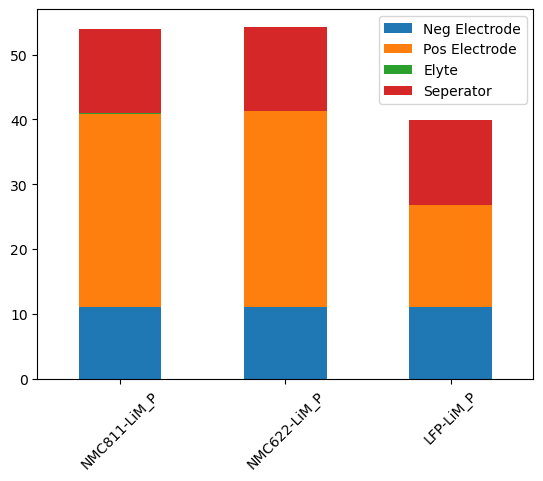

In [23]:
ax = df_Li_share_assb_cells.plot.bar(stacked=True, rot=45)

## Cells using Liquid electrolytes

No Li available in separator, hence zero content coming from there. 

Li mass in electrolyte

In [24]:
df_Elyte_l_mass

,Li_elyte_mass
NMC811-Gr_P,0.836627
NMC622-Gr_P,0.785922
LFP-Gr_P,0.633808


Materials in liquid electrolyte cathodes

In [25]:
df_pos_elec_materials

,Ni,Co,Mn,Li,Al
NMC811-Gr_P,161.606478,20.20081,20.20081,23.567611,0.0
NMC622-Gr_P,122.665891,40.88863,40.88863,23.851701,0.0
LFP-Gr_P,0.000000,0.00000,0.00000,12.434211,0.0


Materials in liquid electrolyte anodes

In [26]:
df_neg_elec_materials

,Gr,Cu
NMC811-Gr_P,221.598837,75.264
NMC622-Gr_P,221.598837,75.264
LFP-Gr_P,221.598837,75.264


Summing up all the Li for cells using liquid electrolytes

In [27]:
Li_total_cells_l = df_pos_elec_materials['Li'] + df_Elyte_l_mass['Li_elyte_mass']
df_Li_total_cells_l = pd.DataFrame(data = Li_total_cells_l, 
                                     index = [cells[0].name_pouch, cells[1].name_pouch, cells[2].name_pouch])
df_Li_total_cells_l.set_axis(['Li_mass_total'], axis=1, inplace = True)
Li_total_cells_by_Wh_l = np.zeros((3,1))
for i in range(0,3):
    Li_total_cells_by_Wh_l[i] = df_Li_total_cells_l['Li_mass_total'].iloc[i] / cells[i].energy
df_Li_total_cells_l['Li_mass_by_Wh'] = Li_total_cells_by_Wh_l
df_Li_total_cells_l

,Li_mass_total,Li_mass_by_Wh
NMC811-Gr_P,24.404238,0.102618
NMC622-Gr_P,24.637623,0.110283
LFP-Gr_P,13.068019,0.085511


Since we don't have any Li containing separator and a Graphite based anode, we have less Li in these cells, as well normalized by Wh. 

In [28]:
df_Li_share_l_cells = pd.DataFrame()
df_Li_share_l_cells['Neg Electrode'] = 0
df_Li_share_l_cells['Pos Electrode'] = df_pos_elec_materials['Li']
df_Li_share_l_cells['Elyte'] = df_Elyte_l_mass['Li_elyte_mass']
df_Li_share_l_cells['Seperator'] = 0
df_Li_share_l_cells

,Neg Electrode,Pos Electrode,Elyte,Seperator
NMC811-Gr_P,NaN,23.567611,0.836627,0
NMC622-Gr_P,NaN,23.851701,0.785922,0
LFP-Gr_P,NaN,12.434211,0.633808,0


Plotting that for the liquied cells: 

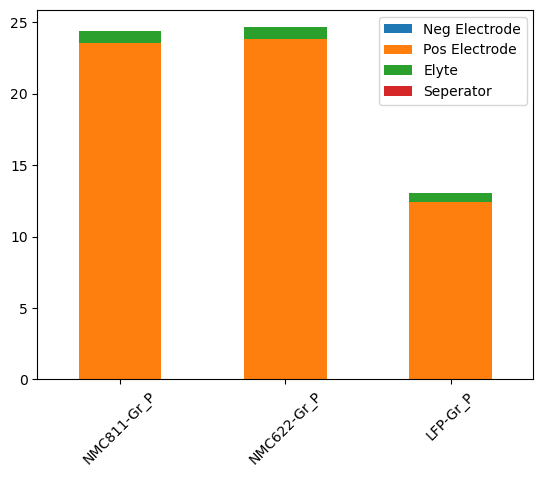

In [29]:
ax = df_Li_share_l_cells.plot.bar(stacked=True, rot=45)

Combining it in one data frame

In [30]:
df_Li_share_l_assb_cells = pd.concat([df_Li_share_l_cells, df_Li_share_assb_cells])
df_Li_share_l_assb_cells

,Neg Electrode,Pos Electrode,Elyte,Seperator
NMC811-Gr_P,NaN,23.567611,0.836627,0.000000
NMC622-Gr_P,NaN,23.851701,0.785922,0.000000
LFP-Gr_P,NaN,12.434211,0.633808,0.000000
NMC811-LiM_P,11.028133,29.852308,0.050984,13.030564
NMC622-LiM_P,11.028133,30.212155,0.047894,13.030564
LFP-LiM_P,11.028133,15.750000,0.038625,13.030564


And plotting it to make the comparison easier: 

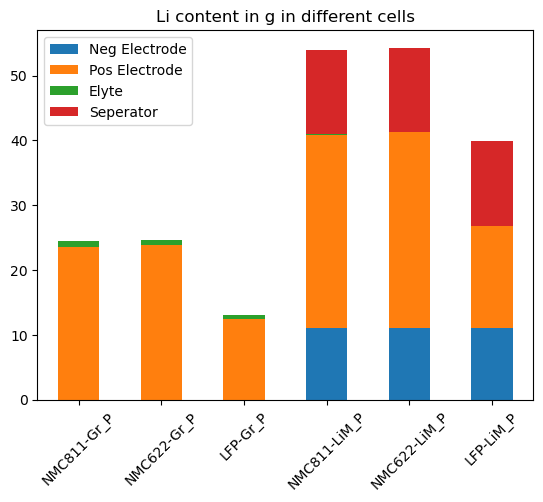

In [31]:
ax = df_Li_share_l_assb_cells.plot.bar(stacked=True, rot=45, title = 'Li content in g in different cells')

# Demand to Li mass

Bloomberg projects a demand only for EVs with up to 2000 GWh by 2030. Since ASSB will likely be used primarily (at the beginning?) in the mobility space, let's go with that. Stationary storage is shown in the graph as well, but that is neglectable. 

https://news.bloomberglaw.com/environment-and-energy/electric-vehicles-to-drive-massive-battery-demand-bnef-chart

<img src="li_demand_forecast.jpeg" /> 

In [32]:
Li_mass_Wh = [df_Li_total_cells['Li_mass_by_Wh'][0], # NMC811-LiM
              df_Li_total_cells['Li_mass_by_Wh'][2], # LFP-LiM
              df_Li_total_cells_l['Li_mass_by_Wh'][0], # NMC811-Gr
              df_Li_total_cells_l['Li_mass_by_Wh'][2], # LFP-Gr
             ]
Li_mass_Wh

[0.21691243889874592,
 0.24731071693062648,
 0.10261780115188363,
 0.08551123082763333]

Let's assume that about 25% of passenger EVs will use ASSB by 2030 (25% * ~1250 GWh). And of that 25%, NMC811 and LFP will have a 50/50 share, just as well to keep assumptions simple and because who knows how LFP and NMC811 will develop (we will likely have NMC90505 or some other fancy number combination with more Ni by then). 
The remaining share will be covered by conventional, liquid-based electrolytes with as well a 50/50 share of NMC811 and LFP. 

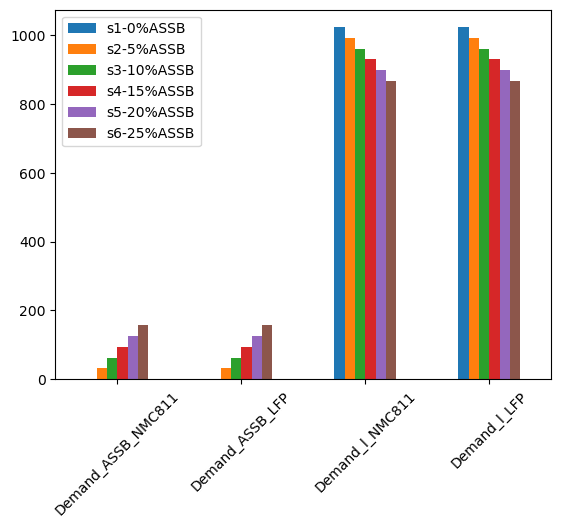

In [33]:
idx = 0
sc = 0
share_nmc_vs_lfp = 0.5
#demand = []
scenarios = ['s1-0%ASSB', 's2-5%ASSB', 's3-10%ASSB', 's4-15%ASSB', 's5-20%ASSB', 's6-25%ASSB']
for idx in range(0,30,5):
    demand_assb = idx/100*1250
    demand_assb_NMC811 = share_nmc_vs_lfp*idx/100*1250
    demand_assb_LFP = demand_assb_NMC811
    demand_l = 2045 - demand_assb
    demand_l_NMC811 = demand_l*share_nmc_vs_lfp
    demand_l_LFP = demand_l_NMC811
    demand_scenario =[demand_assb_NMC811, demand_assb_LFP, demand_l_NMC811, demand_l_LFP]
    #demand = [demand, demand_scenario]
    #df_demand_single = pd.DataFrame(data = demand)
    # df_demand.set_axis(['GWh/y'], axis=1, inplace = True)
    if idx == 0: 
        demand = [demand_scenario]
    
    #    name = scenarios[sc]
    #    df_demand[name] = df_demand_single
    else:
        demand = np.vstack([demand, demand_scenario])
    #    name = scenarios[sc]
    #    df_demand[name] = df_demand_single
    sc = sc +1

df_demand = pd.DataFrame(data = demand, index = scenarios)
df_demand.columns = ['Demand_ASSB_NMC811', 'Demand_ASSB_LFP', 'Demand_l_NMC811', 'Demand_l_LFP']
df_demand = df_demand.T
ax = df_demand.plot.bar(rot=45)

In [34]:
#df_demand['Li_mass_in_kg/GWh'] = Li_mass_Wh # still need to multiply by 1e9 and divide by 1e3 to get kg/GWh
#df_demand['Li_mass_in_kg/GWh'] = df_demand['Li_mass_in_kg/GWh']*1e9/1e3
#df_demand'

So we end up with the following scenarios for the different demand in GWh

In [35]:
df_demand

,s1-0%ASSB,s2-5%ASSB,s3-10%ASSB,s4-15%ASSB,s5-20%ASSB,s6-25%ASSB
Demand_ASSB_NMC811,0.0,31.25,62.5,93.75,125.0,156.25
Demand_ASSB_LFP,0.0,31.25,62.5,93.75,125.0,156.25
Demand_l_NMC811,1022.5,991.25,960.0,928.75,897.5,866.25
Demand_l_LFP,1022.5,991.25,960.0,928.75,897.5,866.25


Now we transform the Li content for the different chemistries from g/Wh in t/GWh to make the calculation easier: 

In [36]:
Li_mass_t_GWh = [value  *1e9/1e6 for value in Li_mass_Wh]
df_Li_mass_t_GWh = pd.DataFrame(data = Li_mass_t_GWh, index = ['Li_mass_ASSB_NMC811', 'Li_mass_ASSB_LFP', 'Li_mass_l_NMC811', 'Li_mass_l_LFP'])
df_Li_mass_t_GWh.columns = ['Li_mass_t/GWh']
df_Li_mass_t_GWh

,Li_mass_t/GWh
Li_mass_ASSB_NMC811,216.912439
Li_mass_ASSB_LFP,247.310717
Li_mass_l_NMC811,102.617801
Li_mass_l_LFP,85.511231


In [37]:
for idx in range(0,len(df_demand.columns.values)):
    Li_demand_in_t_scenario = df_demand.iloc[:,idx].values*df_Li_mass_t_GWh['Li_mass_t/GWh'].values
    if idx == 0:
        Li_demand_in_t = Li_demand_in_t_scenario
    else:
        Li_demand_in_t = np.vstack([Li_demand_in_t, Li_demand_in_t_scenario])
# Li_demand_in_t

In [38]:
df_Li_demand_in_t = pd.DataFrame(data = Li_demand_in_t)
df_Li_demand_in_t.columns = ['Demand_ASSB_NMC811', 'Demand_ASSB_LFP', 'Demand_l_NMC811', 'Demand_l_LFP']
df_Li_demand_in_t.index = scenarios
df_Li_demand_in_t = df_Li_demand_in_t.T

How does that look in total, showing the demand for Li in t per year: 

In [39]:
df_Li_demand_in_t.loc['Total']= df_Li_demand_in_t.sum()
df_Li_demand_in_t

,s1-0%ASSB,s2-5%ASSB,s3-10%ASSB,s4-15%ASSB,s5-20%ASSB,s6-25%ASSB
Demand_ASSB_NMC811,0.000000,6778.513716,13557.027431,20335.541147,27114.054862,33892.568578
Demand_ASSB_LFP,0.000000,7728.459904,15456.919808,23185.379712,30913.839616,38642.299520
Demand_l_NMC811,104926.701678,101719.895392,98513.089106,95306.282820,92099.476534,88892.670248
Demand_l_LFP,87435.233521,84763.007558,82090.781595,79418.555631,76746.329668,74074.103704
Total,192361.935199,200989.876569,209617.817940,218245.759310,226873.700680,235501.642051


Plotting that: 

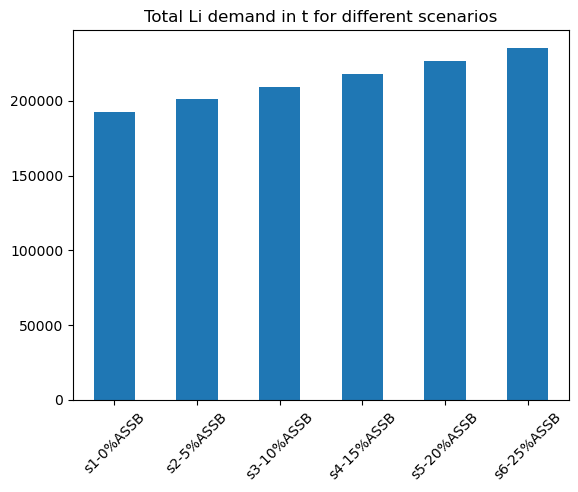

In [49]:
ax = df_Li_demand_in_t.iloc[-1].plot.bar(rot=45, title = 'Total Li demand in t for different scenarios')

Based on BP Statistical Review, we produced 106.000 t of Lithium ("metric tons of Li content") in 2021. 
https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/pdfs/energy-economics/statistical-review/bp-stats-review-2022-full-report.pdf


In [41]:
df_Li_demand_in_t['s6-25%ASSB'].iloc[-1] / df_Li_demand_in_t['s1-0%ASSB'].iloc[-1] * 100 - 100

22.426321926372268

That means, with the assumption that 25% of the mobility demand will be covered in 2030 by ASSB with a 50/50 split NMC/LFP (scenario 6) we have an increase in Li demand of 20%! 

## Key take aways: 
* Li demand (also normalized by energy) is larger for ASSB cells, it can be 2x for NMC and 3x LFP compared to the liquid counterparts. 
* A lot of cell design parameters influence the energy density, 20% SSE in the cathode content seems still challenging but will be needed to make the energy density gain sufficient. 
* With roughly 200.000 t Li demand in 2030 it is obvious, that the Li mining and recycling capacity needs to increase to keep up. To make that possible, the work on the mines need to start now and other sources of Li should be explored. We don't have resource problem, but a resource availability problem. 
* A small portion of ASSB in the market increases the total Li demand significantly. If ASSB take about 25% in the mobility sector representing about 300 GWh/year in the scenario, the total Li demand is increased by more than 20%. 